# Lec 23 - Step Functions
## CMSE 381 - Fall 2023
## Nov 3, 2023



We're going to try again with the step functions.

In [16]:
# Everyone's favorite standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time


# ML imports we've used previously
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm


# 0. Loading in the data

We're going to use the `Wage` data used in the book, so note that many of your plots can be checked by looking at figures in the book.

In [17]:
df = pd.read_csv('../../DataSets/Wage.csv', index_col =0 )
df.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 231655 to 453557
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        3000 non-null   int64  
 1   age         3000 non-null   int64  
 2   sex         3000 non-null   object 
 3   maritl      3000 non-null   object 
 4   race        3000 non-null   object 
 5   education   3000 non-null   object 
 6   region      3000 non-null   object 
 7   jobclass    3000 non-null   object 
 8   health      3000 non-null   object 
 9   health_ins  3000 non-null   object 
 10  logwage     3000 non-null   float64
 11  wage        3000 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 304.7+ KB


In [19]:
df.describe()

,year,age,logwage,wage
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,2005.791000,42.414667,4.653905,111.703608
std,2.026167,11.542406,0.351753,41.728595
min,2003.000000,18.000000,3.000000,20.085537
25%,2004.000000,33.750000,4.447158,85.383940
50%,2006.000000,42.000000,4.653213,104.921507
75%,2008.000000,51.000000,4.857332,128.680488
max,2009.000000,80.000000,5.763128,318.342430


Here's the plot we used multiple times in class to look at a single variable:  `age` vs `wage`

Text(0, 0.5, 'Wage')

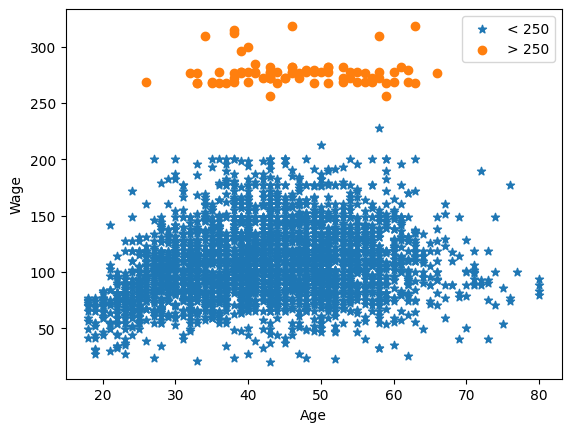

In [20]:
plt.scatter(df.age[df.wage <=250], df.wage[df.wage<=250],marker = '*', label = '< 250')
plt.scatter(df.age[df.wage >250], df.wage[df.wage>250], label = '> 250')
plt.legend()

plt.xlabel('Age')
plt.ylabel('Wage')

# 1. Step functions

Now let's try to use step functions to learn a model using `age` to predict `wage`. Like with the polynomial example from last time, all we're going to do is build a data frame or feature matrix that has the step function values in each column, and then pass that matrix to our favorite linear modeling function. 

First, we want to get a dataframe with the cuts. The `right = False` bit says whether I want the bins to include the right endpoint in the interval. This means our bins end up as $[c_i,c_{i+1})$ which follows the notation in the book.

In [22]:
df

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...,...
376816,2008,44,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
302281,2007,30,1. Male,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
10033,2005,27,1. Male,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
14375,2005,27,1. Male,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


In [23]:
df_cut, bins = pd.cut(df.age, 4, 
                      retbins = True, #<---- Says I want it to return the bins (aka the knots)
                      right = False)

array([18.   , 33.5  , 49.   , 64.5  , 80.062])

I will define the entries in the bins to be the $c_i$'s as follows. 


In [26]:
print(bins)

[18.    33.5   49.    64.5   80.062]


In [27]:
print(r'c_1 = ', bins[0])
print(r'c_2 = ', bins[1])
print(r'c_3 = ', bins[2])
print(r'c_4 = ', bins[3])
print(r'c_5 = ', bins[4])

c_1 =  18.0
c_2 =  33.5
c_3 =  49.0
c_4 =  64.5
c_5 =  80.062


&#9989; **<font color=red>Do this:</font>**
 For each of the functions $C_0(X)$, $C_1(X)$, $C_2(X)$, $C_3(X)$, $C_4(X)$, $C_5(X)$ (following our notation in class), determine the domains where they have value 1. 

*Your answer here*

- $C_0(X)$:
- $C_1(X)$:
- $C_2(X)$: 
- $C_3(X)$: 
- $C_4(X)$: 
- $C_5(X)$: 

Below is my code that generates the data frame storing $C_i(X)$ for all our entries. 

In [28]:
df_steps_dummies = pd.get_dummies(df_cut)
df_steps_dummies.head()

,"[18.0, 33.5)","[33.5, 49.0)","[49.0, 64.5)","[64.5, 80.062)"
231655,1,0,0,0
86582,1,0,0,0
161300,0,1,0,0
155159,0,1,0,0
11443,0,0,1,0


&#9989; **<font color=red>Q:</font>** Which of the functions $C_i(X)$ for $i=0,\cdots, 5$ have columns represented in this matrix? *Note: it's not all of them*


* Your answer here*

One annoying difference from the book is that because our code saw no data in the intervals $(-\infty, 18]$ or  $[80.062,\infty)$ interval, it doesn't make us a column for either of those. This is totally fine as long as later we don't ask our model to predict anything outside of the range $[18.0, 80.062)$ so for the remainder of the notebook, we'll make sure we don't try to pass it anything outside of those values. 

&#9989; **<font color=red>Do this:</font>** Pass this matrix to a linear regression model and use it to predict `wage`. What is the equation for your learned model? Be specific in terms of the $C_i$ functions you learned earlier.

In [29]:
# Your code here #


Assuming you stored your linear regression model as `linreg`, the following code will plot the learned function. Check that the answers you got in the table above match with what you're seeing in the graph.  

In [31]:
t = np.linspace(20,80,100) #<--- Remember my rule that I can't pass anything outisde
                           #     of [18,80.02)

bin_mapping = np.digitize(t, bins)


# print(bin_mapping)
t_dummies = pd.get_dummies(bin_mapping)
t_dummies.head(100)

,1,2,3,4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
95,0,0,0,1
96,0,0,0,1
97,0,0,0,1
98,0,0,0,1


In [37]:
x

,"[18.0, 33.5)","[33.5, 49.0)","[49.0, 64.5)","[64.5, 80.062)"
231655,1,0,0,0
86582,1,0,0,0
161300,0,1,0,0
155159,0,1,0,0
11443,0,0,1,0
...,...,...,...,...
376816,0,1,0,0
302281,1,0,0,0
10033,1,0,0,0
14375,1,0,0,0


In [35]:
y= df.wage

x = df_steps_dummies


from sklearn.linear_model import LinearRegression

linreg = LinearRegression(fit_intercept=False)
linreg.fit(x,y)


LinearRegression(fit_intercept=False)

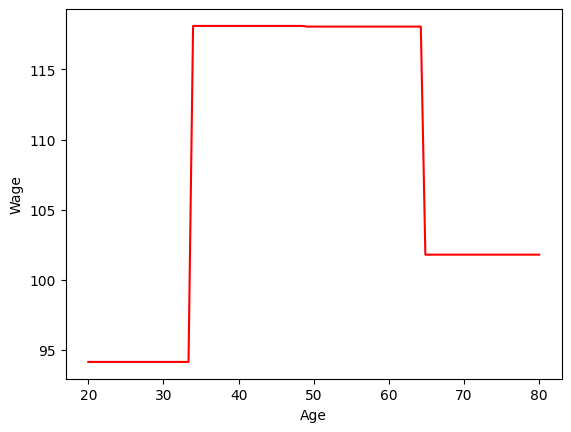

In [36]:



stepPredict = linreg.predict(t_dummies) #<---- If you named your linear regression 
                                        #      something else, you can fix this to match.
            
#--------Uncomment below to draw the scatter plot of the data as well-------#
# plt.scatter(df.age,df.wage,marker = '+')


plt.xlabel('Age')
plt.ylabel('Wage')

plt.plot(t,stepPredict,color='red')


![Stop Icon](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Vienna_Convention_road_sign_B2a.svg/180px-Vienna_Convention_road_sign_B2a.svg.png)

Great, you got to here! Hang out for a bit, there's more lecture before we go on to the next portion. 

# 2.  Classification version of step functions

Now we can try out the classification version of the problem. Let's build the classifier that predicts whether a person of a given age will make more than $250,000. You already made the matrix of step function features, so we just have to hand it to `LogisticRegression` to do its thing.

Text(0, 0.5, 'Wage')

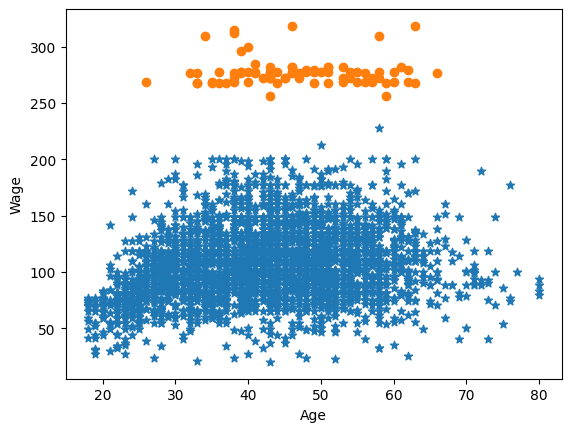

In [38]:

plt.scatter(df.age[df.wage <=250], df.wage[df.wage<=250],marker = '*')
plt.scatter(df.age[df.wage >250], df.wage[df.wage>250])

plt.xlabel('Age')
plt.ylabel('Wage')

# plt.savefig('WageColoredBy250.png', bbox_inches = 'tight')


In [39]:
from sklearn.linear_model import LogisticRegression

In [41]:
y = np.array(df.wage>250) #<--- this makes sure I 
                          #     just have true/false input
clf = LogisticRegression(random_state=48824)
clf.fit(df_steps_dummies,y)

LogisticRegression(random_state=48824)

In [42]:
f = clf.predict_proba(t_dummies)

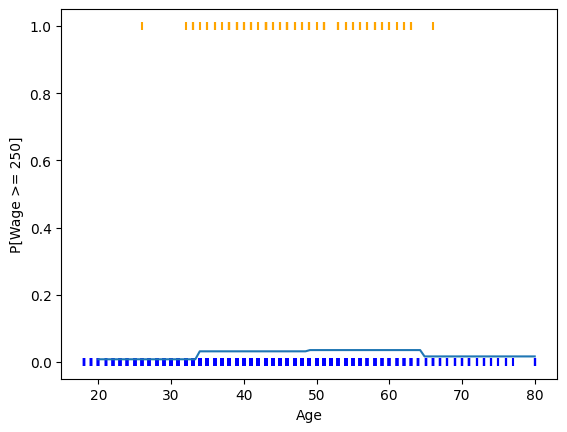

In [43]:
below = df.age[df.wage <=250]
above = df.age[df.wage >250]

# Comment this out to see the function better
plt.scatter(above,np.ones(above.shape[0]),marker = '|', color = 'orange')
plt.scatter(below,np.zeros(below.shape[0]),marker = '|', color = 'blue')



plt.xlabel('Age')
plt.ylabel('P[Wage >= 250]')
plt.plot(t,f[:,1])



-----
### Congratulations, we're done!
Written by Dr. Liz Munch, Michigan State University

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.